In [1]:
NOTE = 'KNNベクトルはPCA'
notebook_name = '031'

In [2]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

031_submission.csv 031


In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

# categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
# discrete_features = list(set(minimal_features) - set(categorical_features))
# print(categorical_features)
# print(discrete_features)

# Execute if categories should be one-hot style
## categorical features
for c in CATEGORICAL_FEATURES:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])
train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)
assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())
categorical_features = []
for c in CATEGORICAL_FEATURES:
    categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
## vector features
vector_features = VECTOR_FEATURES
## discrete features
discrete_features = [c for c in train.columns
                     if c not in ['y', 'id'] + vector_features + categorical_features]
## all features
features = categorical_features + discrete_features + vector_features

len(categorical_features), len(vector_features), len(discrete_features)

(1857, 384, 107)

In [6]:
categorical_features

['batterID_0',
 'batterID_2',
 'batterID_5',
 'batterID_9',
 'batterID_11',
 'batterID_12',
 'batterID_15',
 'batterID_18',
 'batterID_19',
 'batterID_21',
 'batterID_22',
 'batterID_26',
 'batterID_27',
 'batterID_28',
 'batterID_29',
 'batterID_31',
 'batterID_34',
 'batterID_36',
 'batterID_37',
 'batterID_39',
 'batterID_42',
 'batterID_45',
 'batterID_47',
 'batterID_50',
 'batterID_55',
 'batterID_56',
 'batterID_58',
 'batterID_60',
 'batterID_67',
 'batterID_70',
 'batterID_72',
 'batterID_73',
 'batterID_75',
 'batterID_80',
 'batterID_82',
 'batterID_84',
 'batterID_85',
 'batterID_87',
 'batterID_89',
 'batterID_91',
 'batterID_98',
 'batterID_102',
 'batterID_103',
 'batterID_105',
 'batterID_106',
 'batterID_111',
 'batterID_112',
 'batterID_114',
 'batterID_117',
 'batterID_118',
 'batterID_120',
 'batterID_121',
 'batterID_125',
 'batterID_127',
 'batterID_128',
 'batterID_130',
 'batterID_132',
 'batterID_134',
 'batterID_135',
 'batterID_137',
 'batterID_138',
 'batter

In [7]:
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'speedcount',
 'speedmean',
 'speedstd',
 'speedmin',
 'speed25%',
 'speed50%',
 'speed75%',
 'speedmax',
 'speedrange',
 'speedmeanDiff',
 'speedstdDiff',
 'speedminDiff',
 'speed25%Diff',
 'speed50%Diff',
 'speed75%Diff',
 'speedmaxDiff',
 'pitchTypeRatioカットファストボール',
 'pitchTypeRatioカーブ',
 'pitchTypeRatioシュート',
 'pitchTypeRatioシンカー',
 'pitchTypeRatioストレート',
 'pitchTypeRatioスライダー',
 'pitchTypeRatioチェンジアップ',
 'pitchTypeRatioフォーク',
 'battersFaced',
 'gameIDCount',
 'numInningsSum',
 'inningFromMin',
 'inningFromMean',
 'inningFromMedian',
 'inningFromMax',
 'inningFromStd',
 'inningToMin',
 'inningToMean',
 'inningToMedian',
 'inningToMax',
 'inningToStd',
 'pitcherNumStrikeOuts',
 'pitcherNumWalks',
 'hitsAllowed',
 'K/9',
 'BB/9',
 'K1p/BB1p',
 'whips',
 'pitchersFaced',
 'batterNumStrikeOuts',
 'batterNumWa

In [8]:
vector_features

['ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabeld28',
 'ballPositionLabeld29',
 'ballPositionLabeld30',
 'ballPositionLabeld31',
 'ballPositionLabeld32',
 'ballPositionLabeld33',
 'ballPositionLabeld34',
 'ballPositionLabeld35',
 'ballPositionLabe

In [9]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [10]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [11]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    # feature transformation
    ## categorical features
    X_train_categorical = X_train.copy()[categorical_features]
    X_valid_categorical = X_valid.copy()[categorical_features]
    X_test_categorical = test.copy()[categorical_features]
    ## descrete features
    discrete_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    ).fit(X_train.copy()[discrete_features])
    X_train_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_train.copy()[discrete_features]),
        columns=discrete_features,
        index=train_idx
    )
    X_valid_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_valid.copy()[discrete_features]),
        columns=discrete_features,
        index=valid_idx
    )
    X_test_discrete = pd.DataFrame(
        data=discrete_transformer.transform(test.copy()[discrete_features]),
        columns=discrete_features,
        index=test.index
    )
    discrete_transformer.feature_names__ = discrete_features
    discrete_transformer.input_features__ = discrete_features
    with open(os.path.join(OUTPUT_DIR, f'discrete_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(discrete_transformer, f)
        f.close()
    ## vector features
    vector_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('decomposer', PCA(n_components=0.8, whiten=True, random_state=SEED))
        ]
    ).fit(X_train.copy()[vector_features])
    columns = [f'pca{i + 1}' for i in range(vector_transformer[-1].n_components_)]
    X_train_vector = pd.DataFrame(
        data=vector_transformer.transform(X_train.copy()[vector_features]),
        columns=columns,
        index=train_idx
    )
    X_valid_vector = pd.DataFrame(
        data=vector_transformer.transform(X_valid.copy()[vector_features]),
        columns=columns,
        index=valid_idx
    )
    X_test_vector = pd.DataFrame(
        data=vector_transformer.transform(test.copy()[vector_features]),
        columns=columns,
        index=test.index
    )
    vector_transformer.feature_names__ = vector_features
    vector_transformer.input_features__ = vector_features
    with open(os.path.join(OUTPUT_DIR, f'vector_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(vector_transformer, f)
        f.close()
    ## merge
    X_train_transformed = pd.concat([X_train_categorical,
                                     X_train_discrete,
                                     X_train_vector
                                    ],
                                    axis=1)
    X_train_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'train_features_fold{i + 1}.zip'),
        protocol=-1
    )

    X_valid_transformed = pd.concat([X_valid_categorical,
                                     X_valid_discrete,
                                     X_valid_vector
                                    ],
                                    axis=1)
    X_valid_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'valid_features_fold{i + 1}.zip'),
        protocol=-1
    )
    X_test_transformed = pd.concat([X_test_categorical,
                                    X_test_discrete,
                                    X_test_vector
                                   ],
                                   axis=1)
    X_test_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'test_features_fold{i + 1}.zip'),
        protocol=-1
    )
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    # classification    
    clf = KNeighborsClassifier(n_jobs=-1)
    clf.fit(X_train_transformed,
            y_train.values)
    clf.feature_names__ = X_train_transformed.columns.tolist()
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(clf, f)
        f.close()
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train_transformed)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
            'index': train_idx,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid_transformed)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
            'index': valid_idx,
        }
    )
    pred_valid_df['train'] = 1
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(X_test_transformed)
    except AttributeError:
        infer = clf.decision_function(X_test_transformed)
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf.classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)


**********Confusion matrix for train set (Fold 1)**********
[[4092  560  276  129    7    0    0    2]
 [1785 1669  167  109   16    0    0    0]
 [1125  395  783   82    7    1    0    0]
 [ 760  279  183  477   10    0    0    0]
 [ 281  116   46   57   38    2    0    0]
 [  95   14   11   23    2    5    0    0]
 [   3    3    1    1    0    0    0    0]
 [  48   20   11   12    3    0    0    2]]

**********Confusion matrix for validation set (Fold 1)**********
[[745 311 130  75   5   1   0   0]
 [587 211  76  56   6   0   0   0]
 [367 121  81  25   5   0   0   0]
 [243  93  30  58   3   0   0   0]
 [ 84  21   9  17   4   0   0   0]
 [ 21   7   3   6   0   0   0   0]
 [  2   1   0   0   0   0   0   0]
 [ 16   5   2   1   0   0   0   0]]

**********Confusion matrix for train set (Fold 2)**********
[[4095  528  310  115   13    1    0    4]
 [1795 1619  194  116   18    2    0    2]
 [1046  381  856   95   12    2    0    1]
 [ 768  277  181  466   16    0    0    1]
 [ 273  103   4

In [12]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.263985,0.140021
std,0.008807,0.006887
min,0.251281,0.131242
25%,0.262337,0.136725
50%,0.263132,0.139228
75%,0.267727,0.143422
max,0.275450,0.149487


In [13]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,index,train,fold
0,0,0,0,0,0,1
1,1,1,0,1,0,1
2,2,0,0,2,0,1
3,3,2,0,3,0,1
4,4,4,0,4,0,1
...,...,...,...,...,...,...
17126,9690,0,1,17126,1,5
17129,9693,1,1,17129,1,5
17130,16833,1,1,17130,1,5
17133,9762,1,1,17133,1,5


In [14]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.6,0.0,0.4,0.0,0.0,0.0,0.0,0.0,27446,1
1,0.4,0.0,0.6,0.0,0.0,0.0,0.0,0.0,113,1
2,0.4,0.2,0.2,0.2,0.0,0.0,0.0,0.0,4479,1
3,0.4,0.2,0.2,0.2,0.0,0.0,0.0,0.0,29080,1
4,0.0,0.4,0.4,0.0,0.2,0.0,0.0,0.0,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.2,0.6,0.0,0.2,0.0,0.0,0.0,0.0,24272,5
33804,0.6,0.0,0.0,0.2,0.2,0.0,0.0,0.0,29106,5
33805,0.6,0.0,0.0,0.0,0.4,0.0,0.0,0.0,20679,5
33806,0.8,0.0,0.0,0.2,0.0,0.0,0.0,0.0,25901,5


In [15]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,1.4,2.2,0.0,1.4,0.0,0.0,0.0,0.0
1,1,0.2,2.0,0.0,2.8,0.0,0.0,0.0,0.0
2,2,2.2,0.8,0.2,1.6,0.2,0.0,0.0,0.0
3,3,2.2,1.8,0.8,0.0,0.2,0.0,0.0,0.0
4,4,1.2,1.6,0.0,1.6,0.2,0.0,0.0,0.4
...,...,...,...,...,...,...,...,...,...
33803,33803,1.6,1.0,0.8,0.8,0.8,0.0,0.0,0.0
33804,33804,2.2,2.6,0.0,0.2,0.0,0.0,0.0,0.0
33805,33805,2.6,0.8,0.0,0.8,0.8,0.0,0.0,0.0
33806,33806,0.8,2.0,0.8,0.6,0.0,0.8,0.0,0.0


In [16]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,3
2,2,0
3,3,0
4,4,1
...,...,...
33803,33803,0
33804,33804,1
33805,33805,0
33806,33806,1


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.561761
1    0.277686
2    0.035909
3    0.117487
4    0.006359
5    0.000651
7    0.000148
Name: y, dtype: float64

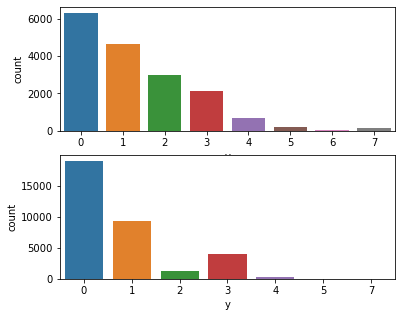

In [17]:
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [18]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [19]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.26398535510707277, 0.14002080538750386)

In [20]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"031_submission.csv","Stratified-Kfold(K=5)","0.263985","0.140021","","KNNベクトルはPCA"


In [21]:
%%time
imp_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 0 ns


In [22]:
imp_df

""


In [23]:
%%time
coef_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [24]:
coef_df

""
